In [2]:
"""
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 -V || python -V

Python 3.11.4


In [1]:
from _requirements import *

## Simulation: Numerical validation of Proposition 1 

In [2]:
## Parameters #####

# Reference shape
p_star = np.array([[-1,-1], [-1,1], [1,1], [1,-1]]) # square
n = p_star.shape[0]

## Generate the simulation frames #####
tf = 2
h = 10

args = {
    "Z"     : ((1,2), (1,3), (2,3), (2,4), (3,4), (4,1)), 
    "p_star": p_star,
    "p0"    : [[-9,-3], [-5,-5], [0,4], [0,-5]],
    "tf"    : tf, 
    "h"     : h,
    "kappa" : 1, 
}

sim_fr = AffineComplexSimulator(**args)

## Design the parameters of a body-fixed desired velocity in S #####
params = [1, 0, 0, 0, 0, 0]
check_case(sim_fr, params, debug=True)

Failed to dualize the problem: 'float' object is not iterable
------------- -> C3 (hxw == 0 and hyw == 0)
l+ = 0j  | l- = 0j
hx - w = 0  | hy + w = 0
vx = 1  | vy = 0
------------- 


In [3]:
## Design M #####
# Set the parameters
vx, vy, a, omega, hx, hy = params

# Design the weights that gerenates the body-fixed desired velocity v_f^*
mu_matrix_x = np.array([[0,0,0,-1], [0,0,-1,0], [0,1,0,0], [1,0,0,0]])/2
mu_matrix_y = np.array([[0,-1,0,0], [1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

mu_matrix_a = np.array([[0,1,0,1], [1,0,1,0], [0,1,0,1], [1,0,1,0]])/2
mu_matrix_w = np.array([[0,1,0,-1], [-1,0,1,0], [0,-1,0,1], [1,0,-1,0]])/2
mu_matrix_hx = np.array([[0,0,0,1], [0,0,-1,0], [0,1,0,0], [-1,0,0,0]])/2
mu_matrix_hy = np.array([[0,1,0,0], [-1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

# Pass the weights to the simulation frame, it will compute M and L_mod
sim_fr.set_manual_mu(
    vx*mu_matrix_x + vy*mu_matrix_y + 
    a*mu_matrix_a + omega*mu_matrix_w + 
    hx*mu_matrix_hx + hy*mu_matrix_hy
)

## Calculate the lower bound of h (h_l) #####
hl = 0 # TODO
print("hl =", hl)

## Launch the simulation #####
sim_fr.numerical_simulation()

hl = 0


Executing numerical simulation: 100%|██████████| 2000/2000 [00:00<00:00, 97575.99it/s]


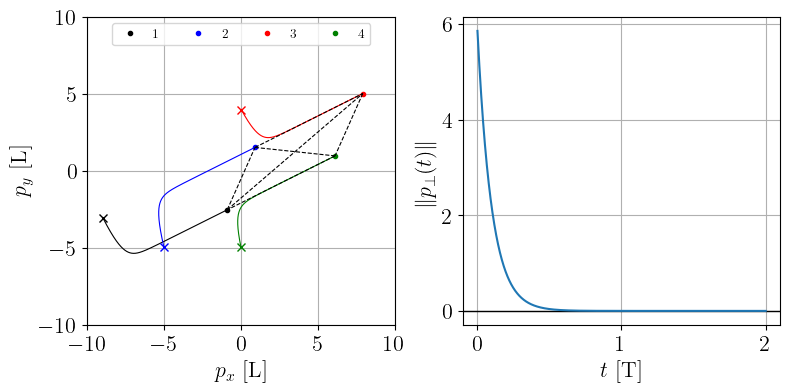

In [4]:
## Generate the paper plot ####

# Init figure and config axes
fig = plt.figure(figsize=(9,4), dpi=100)
ax1, ax2 = fig.subplots(1,2)

# Axis: X-Y
lim = 10
ax1.set_xlim([-lim, lim])
ax1.set_ylim([-lim, lim])
ax1.grid(True)
ax1.set_aspect("equal")

ax1.set_xlabel(r"$p_x$ [L]")
ax1.set_ylabel(r"$p_y$  [L]")

sim_fr.plot(ax1)

ax1.legend(ncols=4, fontsize="xx-small", loc="upper center")

# Axis: ||p_perp||
ax2.grid(True)

ax2.set_xlabel(r"$t$ [T]")
ax2.set_ylabel(r"$\|p_\perp(t)\|$")

ax2.axhline(0, c="k", lw=1)
ax2.plot(sim_fr.data["t"], sim_fr.data["p_perp_norm"])

plt.show()


## Simulation: Numerical validation of Proposition 2

In [5]:
## Parameters #####

# Reference shape
p_star = np.array([[-1,-1], [-1,1], [1,1], [1,-1]]) # square
n = p_star.shape[0]

# Initial condition
ps = p_star[:, 0] + p_star[:, 1] * 1j
lambda d: (d[0] + 1j*d[1])*np.ones(n) + (d[2] + 1j*d[3])*np.real(ps) + (d[4] + 1j*d[5])*np.imag(ps)

## Generate the simulation frames #####
tf = 1
h = 100

args = {
    "Z"     : ((1,2), (1,3), (2,3), (2,4), (3,4), (4,1)), 
    "p_star": p_star,
    "p0"    : p_star,
    "tf"    : tf, 
    "h"     : h,
    "kappa" : 1, 
}

sim_fr = AffineComplexSimulator(**args)

Failed to dualize the problem: 'float' object is not iterable


In [6]:
## Design the parameters of a body-fixed desired velocity in S #####

# Parameters examples ----------------------------------
# C1
params_deg_c1 = [1, 0, 0, 2, 1, 0]

# C2
params_deg_c2 = [0, 0, 1, 1, 2, 0]

# C3
params_deg_c3a = [1, 1, 0, 0, 0, 0]
params_deg_c3b = [1, 0, 0, 0, 4, 0]
params_deg_c3c = [0, 1, 0, 0, 0, 4]

# C4
params_deg_c4a = [1, 0, 0, 0, 0, 4]
params_deg_c4b = [0, 1, 0, 0, 4, 0]
# ------------------------------------------------------

params = params_deg_c3a
check_case(sim_fr, params, debug=True)

------------- -> C3 (hxw == 0 and hyw == 0)
l+ = 0j  | l- = 0j
hx - w = 0  | hy + w = 0
vx = 1  | vy = 1
------------- 


In [7]:
## Design M #####
# Set the parameters
vx, vy, a, omega, hx, hy = params

# Design the weights that gerenates the body-fixed desired velocity v_f^*
mu_matrix_x = np.array([[0,0,0,-1], [0,0,-1,0], [0,1,0,0], [1,0,0,0]])/2
mu_matrix_y = np.array([[0,-1,0,0], [1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

mu_matrix_a = np.array([[0,1,0,1], [1,0,1,0], [0,1,0,1], [1,0,1,0]])/2
mu_matrix_w = np.array([[0,1,0,-1], [-1,0,1,0], [0,-1,0,1], [1,0,-1,0]])/2
mu_matrix_hx = np.array([[0,0,0,1], [0,0,-1,0], [0,1,0,0], [-1,0,0,0]])/2
mu_matrix_hy = np.array([[0,1,0,0], [-1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

# Pass the weights to the simulation frame, it will compute M and L_mod
sim_fr.set_manual_mu(
    vx*mu_matrix_x + vy*mu_matrix_y + 
    a*mu_matrix_a + omega*mu_matrix_w + 
    hx*mu_matrix_hx + hy*mu_matrix_hy
)

## Calculate the lower bound of h (h_l) #####
hl = 0
print("hl =", hl)

## Launch the simulation and plot #####
sim_fr.numerical_simulation()

hl = 0


Executing numerical simulation: 100%|██████████| 1000/1000 [00:00<00:00, 68975.05it/s]


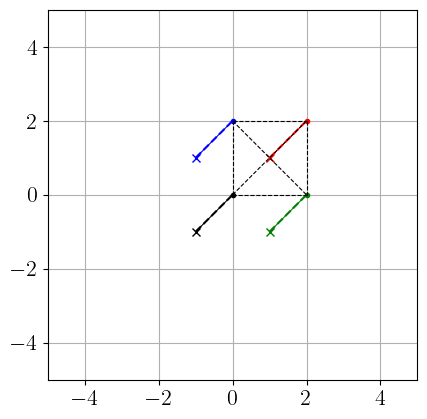

In [8]:
pt_parallel = get_pt_parallel(sim_fr, params, [0,1,1])

# Evaluate
t_list = np.linspace(0,sim_fr.tf,100)
p_eval = []

for t in t_list:
    p_eval.append(pt_parallel(t))
p_eval = np.array(p_eval)

# Plot analytical solution
fig = plt.figure()
ax = fig.subplots()

lim = 5
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])

ax.grid(True)
ax.set_aspect("equal")

colors = ["k", "b", "r", "g"]
for i in range(4):
    ax.plot(np.real(p_eval)[:,i], np.imag(p_eval)[:,i], c=colors[i], ls="--")

# Plot the simulation
sim_fr.plot(ax)

plt.show()
